In [1]:
from netCDF4 import Dataset
import numpy as np
import pickle
import multiprocessing
import pandas as pd
import geopandas as gpd
out_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/stage_4_totals/yearly/{year}.pickle'
fn_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/precipitation/stage4/{year}_stage4_hourly.nc'


In [8]:

def yearly_totals(year):
    fn = fn_fmt.format(year = year)
    f = Dataset(fn)
    
    arr_shape = f.variables['p01m'].shape
    a_cum = np.empty((arr_shape[1],arr_shape[2]))
    for i in range(arr_shape[0]):
        data = f.variables['p01m'][i,:,:].data
        data[data>1000] = 0
        a_cum = a_cum + data
    f.close()
    grid_x, grid_y = np.meshgrid(np.arange(1121),np.arange(881))
    grid_xy = grid_x*10**4 + (grid_y) + 10**8
    a_cum[a_cum<0.1] = 0
    # df = pd.DataFrame({'grid_xy': grid_xy.ravel(), 'p':a_cum.ravel()})
    
    # fn_out_pickle = out_fmt.format(year = year)
    # with open(fn_out_pickle, 'wb') as handle:
    #     pickle.dump(df, handle, protocol= pickle.HIGHEST_PROTOCOL)
    return a_cum
    print(year)
    # return a_cum
a_cum = yearly_totals(2001)
# for year in range(2000,2021):
#     yearly_totals(year)

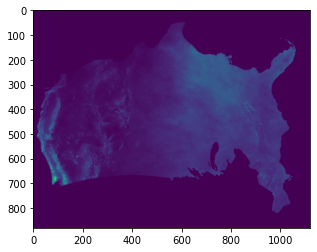

In [9]:
import matplotlib.pyplot as plt
plt.imshow(a_cum)

In [5]:
year = 2001
dt_fmt = '{year}-1-1 23:00'
start_dt = dt_fmt.format(year = year)
end_dt = dt_fmt.format(year = year + 5)
dt_vec = pd.date_range(start=start_dt, end=end_dt, closed='left', freq='60min')
# dt_vec_m = dt_vec.month
print(np.where(dt_vec == pd.to_datetime('2004-3-3 12:00') )

(array([27757]),)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from netCDF4 import Dataset
fn_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/precipitation/stage4/{year}_stage4_hourly.nc'
missing_data = [(2003,7),(2003,8), (2004,3)]
for instance in missing_data:
    
    year, month = instance 
    dt_fmt = '{year}-1-1'
    start_dt = dt_fmt.format(year = year)
    end_dt = dt_fmt.format(year = year + 1)

    dt_vec = pd.date_range(start=start_dt, end=end_dt, closed='left', freq='60min')
    dt_vec_m = dt_vec.month

    idx_0 = np.where(dt_vec_m==month)[0][0]
    idx_n = np.where(dt_vec_m==month)[0][-1]

    # year = 2004
    fn = fn_fmt.format(year = year)
    f = Dataset(fn)
    f.set_auto_mask(True)
    lon = f.variables['lon'][:].data
    lat = f.variables['lat'][:].data
    # lon,lat = np.meshgrid(lon, lat)

    cm1 = plt.cm.get_cmap('Blues',10-0)

    fps = 10

    fig, ax = plt.subplots( figsize=(15,15) , tight_layout=True)

    a = np.flipud(f.variables['p01m'][idx_0, :, :].data)
    im = ax.imshow(a, cmap=cm1, vmax=20, vmin=0)

    def animate_func(i):
        if i % fps == 0:
            print( '.', end ='' )
        ax.text(0.5, 1, str(i) + '\n' + str(dt_vec[idx_0+i]) ,
                bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 5},
                transform=ax.transAxes, ha="center", fontsize=20)
        a = f.variables['p01m'][idx_0+i, :, :].data
        # a[a==0] = -9999
        im.set_array(np.flipud(a))
        return [im]

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = idx_n-idx_0,
                                interval = 1000 / fps, # in ms
                                )
    plt.axis('off')
    plt.tight_layout()
    anim.save('{year}_{month}.mp4'.format(year = year, month = month), fps=fps, extra_args=['-vcodec', 'libx264'])



In [ ]:
import xarray as xr
# import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
fn_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/precipitation/stage4/{year}_stage4_hourly.nc'
fps = 10
# year = 2004
instance = (2004,3)
year, month = instance 
dt_fmt = '{year}-1-1'
start_dt = dt_fmt.format(year = year)
end_dt = dt_fmt.format(year = year + 1)

dt_vec = pd.date_range(start=start_dt, end=end_dt, closed='left', freq='60min')
dt_vec_m = dt_vec.month

idx_0 = np.where(dt_vec_m==month)[0][0]
idx_n = np.where(dt_vec_m==month)[0][-1]
fn = fn_fmt.format(year = year)
ds = xr.open_dataset(fn)
cm1 = plt.cm.get_cmap('Blues',10-0)

proj=ccrs.LambertConformal(central_longitude=-100)
fig, ax = plt.subplots(  subplot_kw={'projection': proj},dpi=300)
air = ds.p01m.isel(time=idx_0)
# air = air.where(lambda x: x == 0, drop=True)
# ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
im = air.plot(x='lon',y='lat', ax=ax,transform=ccrs.PlateCarree(), vmin=1, vmax=10, cmap =cm1,)


# ax.gridlines()
# plt.savefig('cartopy_example.png', dpi=250)
def animate_func(i):
    if i % fps == 0:
        print( '.', end ='' )
    # ax.text(0.5, 1, str(i) + '\n' + str(dt_vec[idx_0+i]) ,
    #         bbox={'facecolor': 'gray', 'alpha': 0.5, 'pad': 5},
    #         transform=ax.transAxes, ha="center", fontsize=10)
    im.set_array(ds.p01m.isel(time=idx_0+i))
    # ax.set_title('new_title', loc='left')
    ax.set_title(str(dt_vec[idx_0+i]))
    return [im]

anim = animation.FuncAnimation(
                            fig, 
                            animate_func, 
                            frames = 10, #idx_n-idx_0,
                            interval = 1000 / fps, # in ms
                            )
# plt.axis('off')
ax.coastlines()
plt.tight_layout()
anim.save('{year}_{month}_xarray.mp4'.format(year = year, month = month), fps=fps, bitrate=-1, extra_args=['-vcodec', 'libx264'])

In [5]:
ax.set_title('a')

Text(0.5, 1.0, 'a')

In [8]:
ax

<GeoAxesSubplot:title={'center':'a'}, xlabel='Longitude [degrees_east]', ylabel='Latitude [degrees_north]'>

In [15]:
def make_figure():
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # generate a basemap with country borders, oceans and coastlines
    ax.add_feature(cfeat.LAND)
    ax.add_feature(cfeat.OCEAN)
    ax.add_feature(cfeat.COASTLINE)
    ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    return fig, ax

# make_figure();

In [16]:
year = 2004
fn = fn_fmt.format(year = year)
ds = xr.open_dataset(fn)


In [128]:
fig = plt.figure( figsize=(15,10) )
year = 2004
fn = fn_fmt.format(year = year)
f = Dataset(fn)
a = f.variables['p01m'][idx_0, :, :].data
# im = plt.imshow(a, cmap=cm1, vmax=5000, vmin=100)
im

<Figure size 1080x720 with 0 Axes>

In [129]:
a

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [94]:
import pickle
def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test

import pandas as pd
pickle_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/stage_4_totals/yearly/{year}.pickle'

data = dict()
stats = []
for year in range(2000,2021):
    fn_in = pickle_fmt.format(year = year)
    data[year] = read_pickle(fn_in)
    # test = data[year][0]['p']
    # stats.append([year, np.max(test[test<4000])])




In [18]:
fn_in = pickle_fmt.format(year = 2002)
data[2002] =     read_pickle(fn_in)

In [24]:
np.sum(data[2002][0]['p'])

370123890.96999824

In [33]:
sum(data[2001][0]['p'] == data[2001][0]['p']) - sum(data[2001][0]['p'] == data[2000][0]['p'])

725162

In [32]:
data[2002]

[          grid_xy    p
 0       100000000  0.0
 1       100010000  0.0
 2       100020000  0.0
 3       100030000  0.0
 4       100040000  0.0
 ...           ...  ...
 987596  111160880  0.0
 987597  111170880  0.0
 987598  111180880  0.0
 987599  111190880  0.0
 987600  111200880  0.0
 
 [987601 rows x 2 columns]]

In [47]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker
from datetime import datetime
import geopandas as gpd

def read_pickle(fn):
    data_test = []
    with open(fn, 'rb') as handle:
        try:
            while True:
                data_test.append(pickle.load(handle))
        except EOFError:
            pass
    return data_test
fn_st_grid_masked = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/gis_files/st4/stage4_grid_new.shp'
fn_us_states = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/gis_files/conus/conus_states.geojson'
pickle_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/stage_4_totals/yearly/{year}.pickle'
var_list = {
    'h':        {'max':5000, 'min':0, 'label': 'Total Depth [$mm$]', 'bw':3,'nbins':20, 'cmap':'Blues'}
    }
st4_grid_masked = gpd.read_file(fn_st_grid_masked)
us_states = gpd.read_file(fn_us_states)
us_states = us_states.to_crs(4326)

xlim = ([us_states.total_bounds[0],  us_states.total_bounds[2]])
ylim = ([us_states.total_bounds[1],  us_states.total_bounds[3]])
variable = 'h'

for year in range(2000,2001):
    in_pickle = pickle_fmt.format(year = year)
    summary = read_pickle(in_pickle)
    summary = summary[0]
    
    data = st4_grid_masked.merge(summary)
    out_pth = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/figures/st4/yearly_totals'
    out_fn = '{variable}_{year}.jpg'.format(variable = variable, year=year)

    if not os.path.exists(out_pth):
        os.makedirs(out_pth)

    fn_temp = '{variable}.png'
    cm1 = plt.cm.get_cmap(var_list[variable]['cmap'],var_list[variable]['nbins']-0)
    fig, ax = plt.subplots(figsize=(20, 16))

    a = data.plot(ax=ax, column='p', edgecolor='none', cmap=cm1, vmin = var_list[variable]['min'], vmax=var_list[variable]['max'], zorder = 0)
    us_states.plot(ax=ax, facecolor="none", edgecolor="black", zorder = 1, alpha=0.2)
    
    ax.set_axis_off()
    # dt_str = '2020-{month}-1'.format(month = month)
    # mnth_name = pd.to_datetime(dt_str).month_name()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.text(0.42,-0.03, str(year),transform=ax.transAxes, fontsize=30)
    cax = fig.add_axes([0.1, 0.15, 0.8, 0.04])
    fig.colorbar( a.collections[0], cax=cax, orientation='horizontal')
    cax.set_xlabel(var_list[variable]['label'], fontsize=20)

    cax.tick_params(labelsize=18)
    
    x_d = np.linspace(var_list[variable]['min'], var_list[variable]['max'], var_list[variable]['nbins']+1)
    
    labels = []
    for i,x in enumerate(x_d):
        if i%2==0:
            if variable in ['tb', 'tr', 'count','h']:
                labels.append(str(int(x)))
            else:
                labels.append(str(x))
        else:
            labels.append('')


    cax.xaxis.set_major_locator(ticker.FixedLocator(x_d))
    cax.xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    fn_out = os.path.join(out_pth,out_fn)
    fig.savefig(fn_out, dpi=300, bbox_inches='tight')
    # plt.close(fig)
    plt.close('all')


In [46]:
st4_grid_masked['grid_xy'].dtype

dtype('int64')

In [2]:
from netCDF4 import Dataset
import numpy as np
import pickle
import multiprocessing
import pandas as pd
import geopandas as gpd
out_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/stage_4_totals/yearly/{year}.pickle'
fn_fmt = '/storage/coda1/p-rbras6/0/njadidoleslam3/precipitation/stage4/{year}_stage4_hourly.nc'

year = 2000
fn = fn_fmt.format(year = year)
f = Dataset(fn)
# f.set_auto_mask(False)
# f.set_auto_scale(True)
data1 = np.array(f.variables['p01m'][0, : , :].data)

In [3]:
data1

array([[65535., 65535., 65535., ..., 65535., 65535., 65535.],
       [65535., 65535., 65535., ..., 65535., 65535., 65535.],
       [65535., 65535., 65535., ..., 65535., 65535., 65535.],
       ...,
       [65535., 65535., 65535., ..., 65535., 65535., 65535.],
       [65535., 65535., 65535., ..., 65535., 65535., 65535.],
       [65535., 65535., 65535., ..., 65535., 65535., 65535.]])

In [33]:
fn_st_grid_masked = '/storage/coda1/p-rbras6/0/njadidoleslam3/projects/stochsm/data/gis_files/st4/stage4_grid_new.shp'
st4_grid_masked = gpd.read_file(fn_st_grid_masked)

In [43]:
grid_x, grid_y = np.meshgrid(np.arange(1121),np.arange(881))
grid_xy = grid_x*10**4 + (grid_y) + 10**8
a_cum[a_cum<0.1] = 0
df = pd.DataFrame({'grid_xy': grid_xy.ravel(), 'p':a_cum.ravel()})





df['grid_xy'] = df['grid_xy'].astype(np.int64)
merged = st4_grid_masked.merge(df)
fn_out_json = out_fmt.format(year = 2000)
merged.to_file(fn_out_json, driver = 'GeoJSON')

In [45]:

with open('test_2000.pickle', 'wb') as handle:
    pickle.dump(df, handle, protocol= pickle.HIGHEST_PROTOCOL)

In [ ]:
pool = multiprocessing.Pool(processes=2)
years = [x for x in range(2000,2021)]
r = pool.map(useless, years)
pool.close()

In [28]:
useless(2000)

2000
